# Settup

In [1]:
!pip3 install virtualenv
! virtualenv -p python3.8 venv
!source /content/venv/bin/activate
!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2.git'
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2.git'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 11.9 MB/s 
     |████████████████████████████████| 468 kB 25.8 MB/s 
created virtual environment CPython3.8.16.final.0-64 in 1340ms
  creator CPython3Posix(dest=/content/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==22.3.1, setuptools==65.6.3, wheel==0.38.4
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 15.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=130c960fd4278274f8eb017aeb652297b4b36df941c822e0b41c0b1e39a593

In [3]:
import numpy as np
import os, json, cv2, random
import tensorflow as tf
import sys, os, distutils.core
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from scipy.signal import medfilt
from scipy import ndimage

# Downloading the images

In [40]:
! mkdir images
!wget -P /content/images http://farm9.staticflickr.com/8207/8159246989_8e0277eb28_z.jpg 
!wget -P /content/images https://farm4.staticflickr.com/3273/5856556022_cdf8a76621_z.jpg
!wget -P /content/images http://farm9.staticflickr.com/8461/8003795209_3a8d8fa57b_z.jpg
!wget -P /content/images http://farm4.staticflickr.com/3816/9474210296_d5de954af8_z.jpg
!wget -P /content/images http://farm4.staticflickr.com/3726/10131940315_e8b4e6602e_z.jpg
!wget -P /content/images http://farm2.staticflickr.com/1287/4672762960_947bbcd2c5_z.jpg

--2022-12-22 10:32:25--  http://farm9.staticflickr.com/8207/8159246989_8e0277eb28_z.jpg
Resolving farm9.staticflickr.com (farm9.staticflickr.com)... 18.65.32.82, 2600:9000:2204:5600:0:5a51:64c9:c681, 2600:9000:2204:2800:0:5a51:64c9:c681, ...
Connecting to farm9.staticflickr.com (farm9.staticflickr.com)|18.65.32.82|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm9.staticflickr.com/8207/8159246989_8e0277eb28_z.jpg [following]
--2022-12-22 10:32:25--  https://farm9.staticflickr.com/8207/8159246989_8e0277eb28_z.jpg
Connecting to farm9.staticflickr.com (farm9.staticflickr.com)|18.65.32.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/content/images/8159246989_8e0277eb28_z.jpg’

8159246989_8e0277eb     [ <=>                ] 100.41K  --.-KB/s    in 0.005s  

2022-12-22 10:32:25 (17.9 MB/s) - ‘/content/images/8159246989_8e0277eb28_z.jpg’ saved [102824]

--2022-12-22 10:32:25

# Dataloader
We don't want to save all images on RAM, so we'll implement a use a dataloader and load from disk our images one at a time.

In [41]:
class ImageDataset(Dataset):
  def __init__(self,img_dir):
    """
     Parameters:
    -----------
      img_dir: str, the path of the dirctory images are in
    """
    self.__img_path = [os.path.join(img_dir, file_name) for file_name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, file_name))]

  def __len__(self):
    """
    returning the amount of images in the folder
    """
    return len(self.__img_path)
  
  def __getitem__(self, index: int):
    """
    get a single (image,image_label) for i'th index
    
     Parameters:
    -----------
      index: int
    :return tuple of image and it's label
    """
    path = self.__img_path[index]
    image = cv2.imread(path)
    return image

# Crop class
The flow of the our cropper is:
1. load image
2. perform obj detection using detectron2
3. get the boundry of the highest obj detected
4. detect sky in the image
5. get the overlap point between the highest detected obj and sky
6. crop the image in the ovelap point.

Downsides in the implementation:
1. sky detection - To detect the sky I used an algorithm to detect skyline and from that I infer about the actual sky limit. 
2. not infrenig sky objects - there maybe objects detection regarding sky like clouds. it need to be handled becuse it probebly not an object we would want to keep in the picure.

ways to improve:
1. semantic segmentation - with training a CNN to perfrom semantic segmentation we can detect the sky way better and in varius environments(e.g nature, urban etc).
Moreover we can focus on the classes inside the image we acully care about. 
using semantic segmentation can solve the two downsides I mentioned.
2. before even detecting the sky we can remove from the image(after the object detection) the boxes on the object we less care about and it can solve downsides 2.

In [44]:
class Cropper:
  def __init__(self,img_dir):
    """
    parameters
    ----------
    img_dir: str, the path of the dirctory images are in
    """
    self.__image_loader = ImageDataset(img_dir)
    self.cfg = self.get_config()
    self.predictor = DefaultPredictor(self.cfg)



  def get_config(self):
    """
    setting up configurations for detecron2  `DefaultPredictor`
    """
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    cfg.MODEL.DEVICE = 'cuda'
    return cfg

  def cal_skyline(self,mask):
    h, w = mask.shape
    for i in range(w):
        raw = mask[:, i]
        after_median = medfilt(raw, 19)
        try:
            first_zero_index = np.where(after_median == 0)[0][0]
            first_one_index = np.where(after_median == 1)[0][0]
            if first_zero_index > 20:
                mask[first_one_index:first_zero_index, i] = 1
                mask[first_zero_index:, i] = 0
                mask[:first_one_index, i] = 0
        except:
            continue
    return mask


  def get_sky_region(self,img):

      h, w, _ = img.shape

      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      img_gray = cv2.blur(img_gray, (9, 3))
      cv2.medianBlur(img_gray, 5)
      lap = cv2.Laplacian(img_gray, cv2.CV_8U)
      gradient_mask = (lap < 6).astype(np.uint8)

      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))

      mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel)
      mask = self.cal_skyline(mask)
      after_img = cv2.bitwise_and(img, img, mask=mask)

      return after_img

  def get_prdictor(self):
    return self.predictor

  def get_image_with_obj_detection(self,img):
    # obj detection prfoming by detecron2 
    predicted_obj = self.get_prdictor()(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]), scale=1.2)
    # drawig the object's boxes on the image
    out = v.draw_instance_predictions(predicted_obj["instances"].to("cpu"))
    # getting the image with boxes 
    detected_img = out.get_image()
    #getting boxes positions
    objects_locations =  predicted_obj["instances"].pred_boxes
    return detected_img, objects_locations 

  def get_image_with_sky_detection(self,img):
    return self.get_sky_region(img)

  def get_highes_object_detected(self,objects_locations):
    """
    we want to get the highest detected object for a cropping bounrdy

    parameters
    ----------  
      objects_locations: list of tensors, each tensor has 4 cordinates which define the object location 
    """
    maxy = float('inf') 
    for loc in objects_locations:
      x0, y0, x1, y1 = loc
      maxy = min(maxy,y1)
    return maxy 

  def get_sky_threshold(self,obj_pos, sky_detect_img):
    """
    we want to get the sky line buondry to match with the object's boundry 
    so we can crop the sky from the image without cropping objects

    parametrs
    ---------
      obj_pos: float, the Y position of highest object
      sky_detect_img: tensor, tensor that represents the image after sky detection

    """
    row,col,chanel = sky_detect_img.shape
    for i in range(row):
      # Loop over the columns of the image
      for j in range(col):
        # Get the pixel values
        r, g, b = sky_detect_img[i, j]
        
        # Check if the pixel is dark (i.e., all color channel values are low)
        if all([r==0, g==0,b==0, i > obj_pos]):
          # Update the highest point
          highest_point = i
          break
      else:
        continue
      break
    return highest_point
  def display(self,img):
    cv2_imshow(img)

  def detect_and_crop(self,index):
    """
    This method's job is to perform the full process:
    1. obj detection 
    2. crooping the sky out of the image while not obj detection not hurmed  

    parameters
    ---------
      index: int, the index of an image in the imageloader

    """
    # getting the image
    img = self.__image_loader[index]
    print("\nOriginal image\n")
    self.display(img)
    obj_detection_img, objects_locations  = self.get_image_with_obj_detection(img)
    print("\nImage with object detection \n")
    self.display(obj_detection_img)
    max_obj_location = self.get_highes_object_detected(list(objects_locations))
    sky_detect_img = self.get_image_with_sky_detection(img)
    sky_threshold = self.get_sky_threshold(max_obj_location,sky_detect_img)
    cropped_img =  obj_detection_img[sky_threshold:, :, ::-1]
    print("\Croped image\n")
    self.display(cropped_img)
    return cropped_img
    






now we test our cropper

[12/22 10:44:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...

Original image



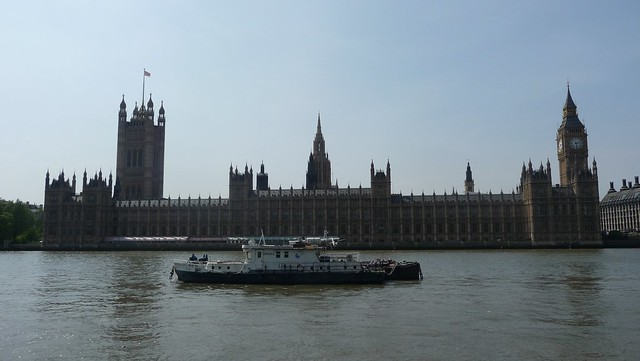


Image with object detection 



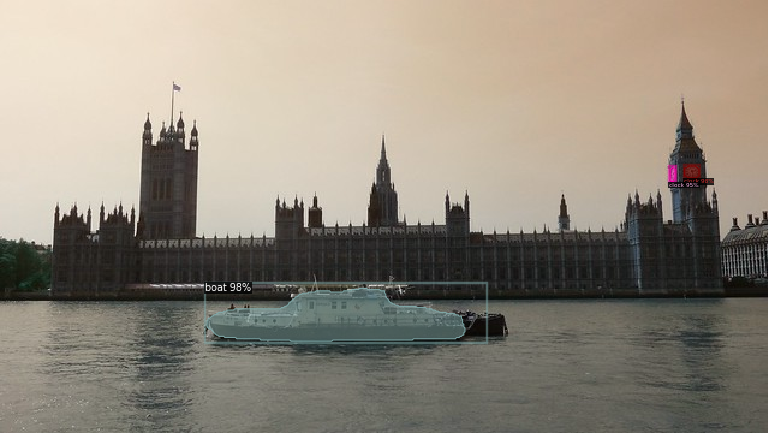

\Croped image



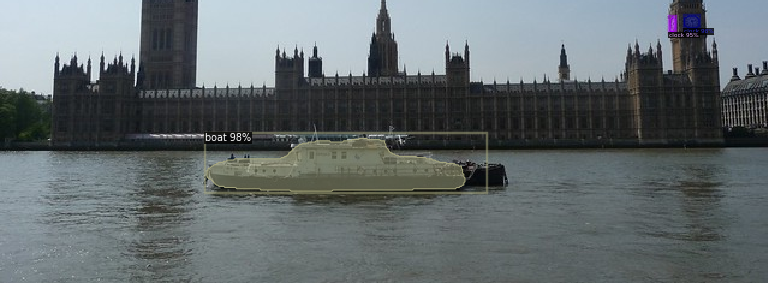


Original image



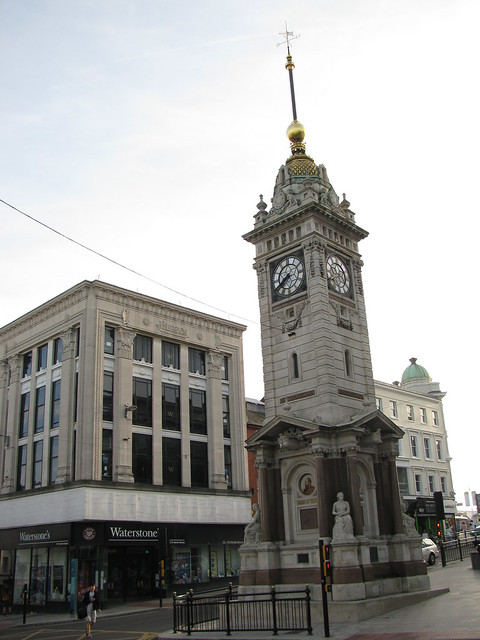


Image with object detection 



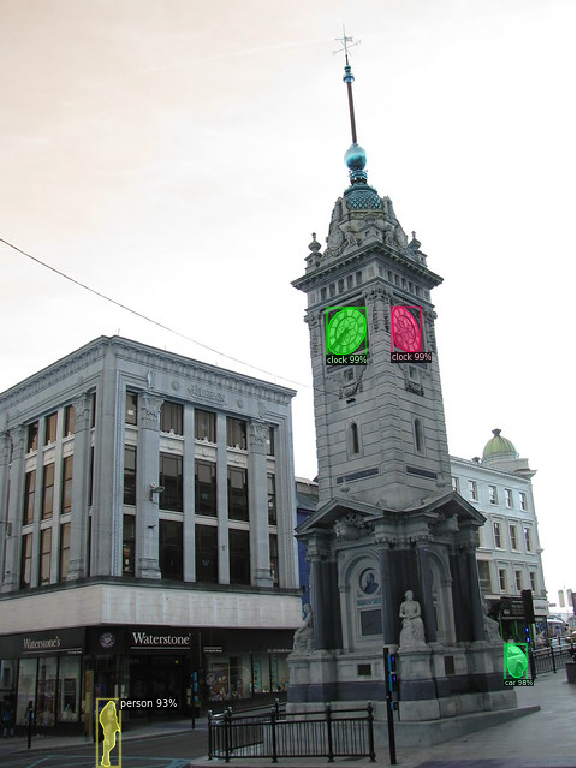

\Croped image



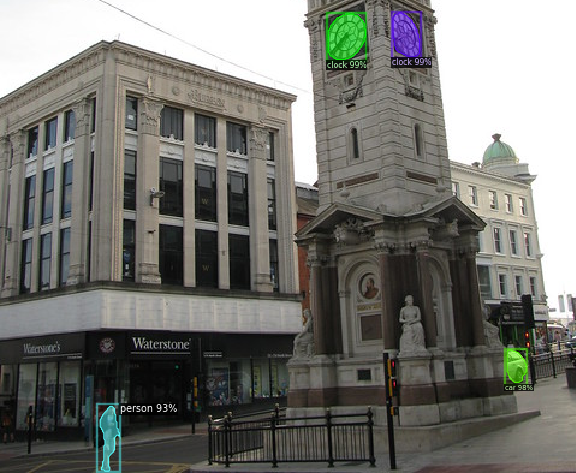


Original image



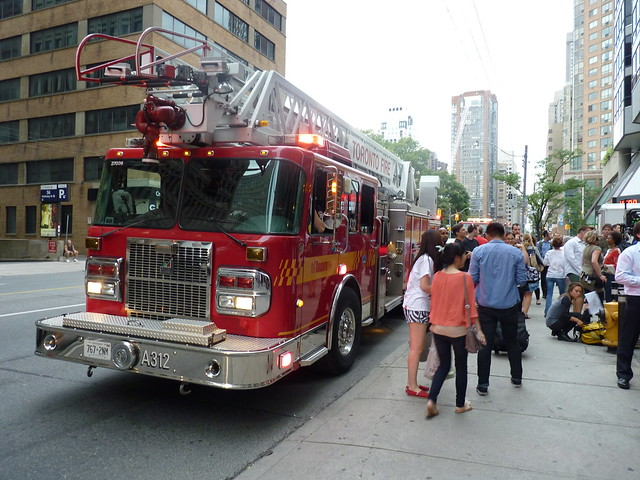


Image with object detection 



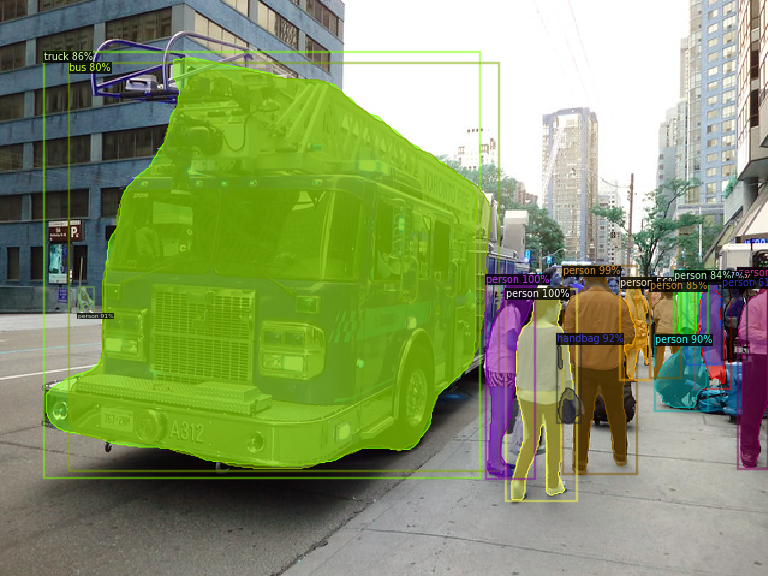

\Croped image



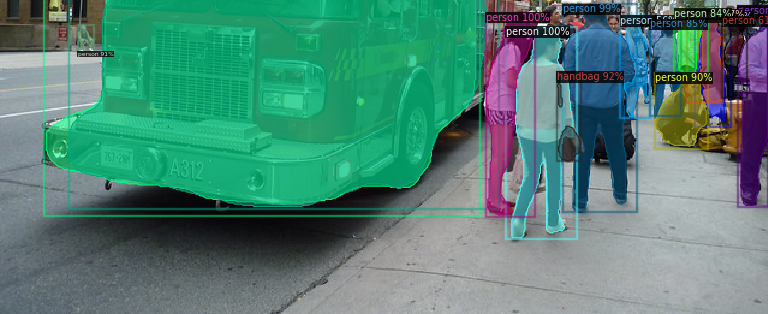


Original image



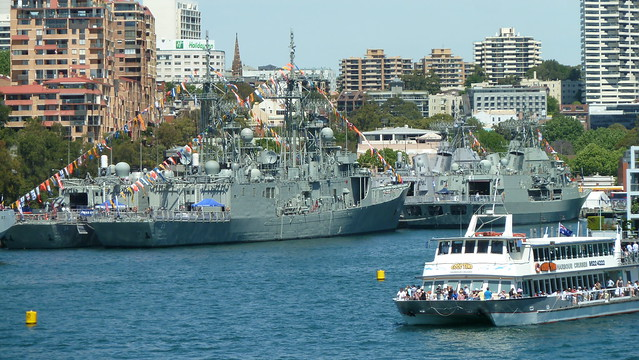


Image with object detection 



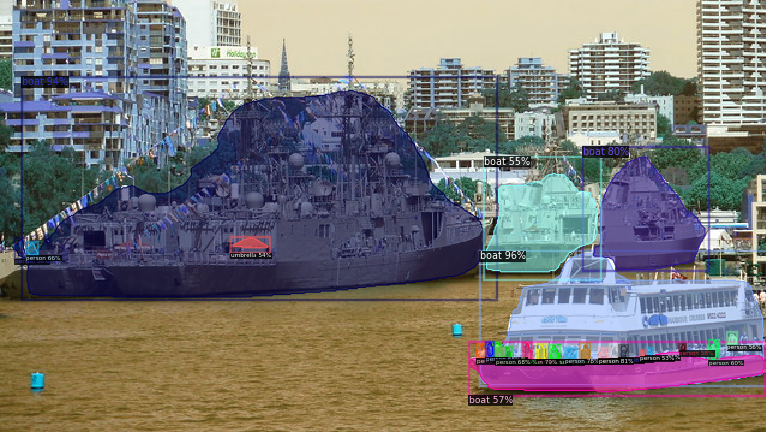

\Croped image



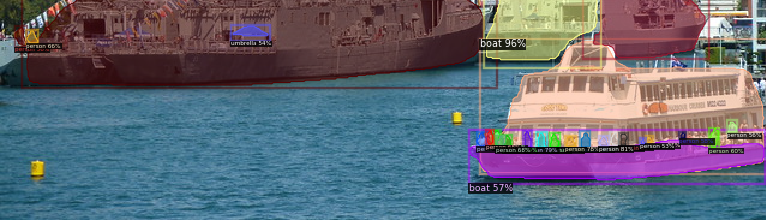


Original image



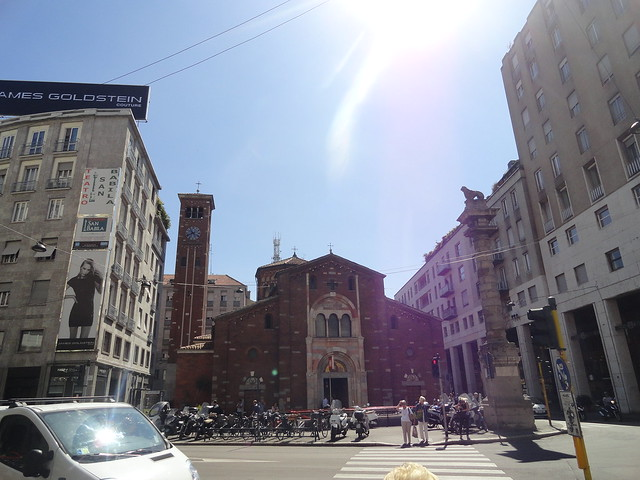


Image with object detection 



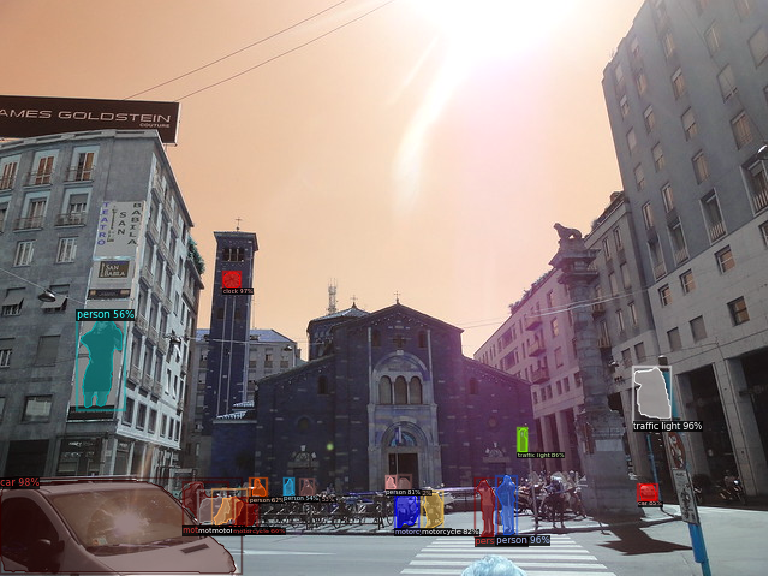

\Croped image



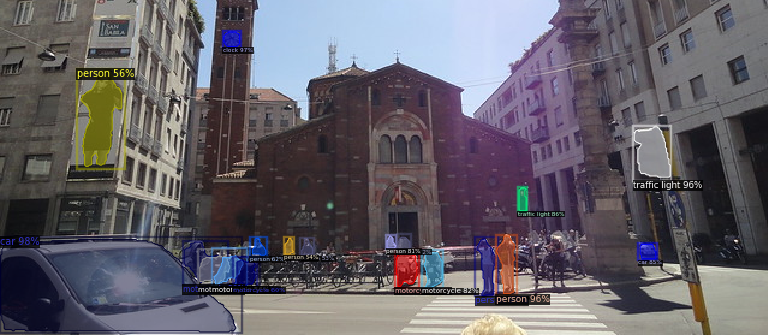


Original image



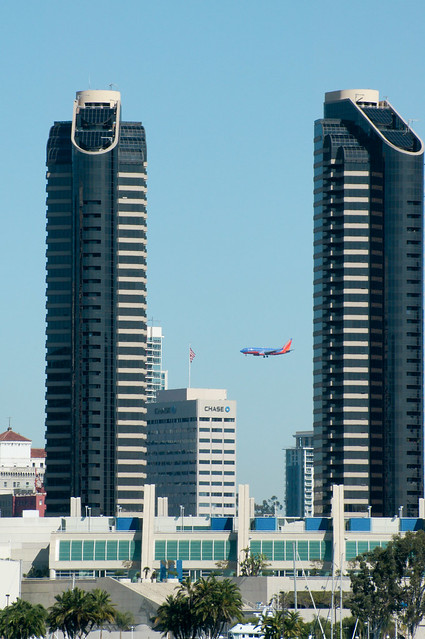


Image with object detection 



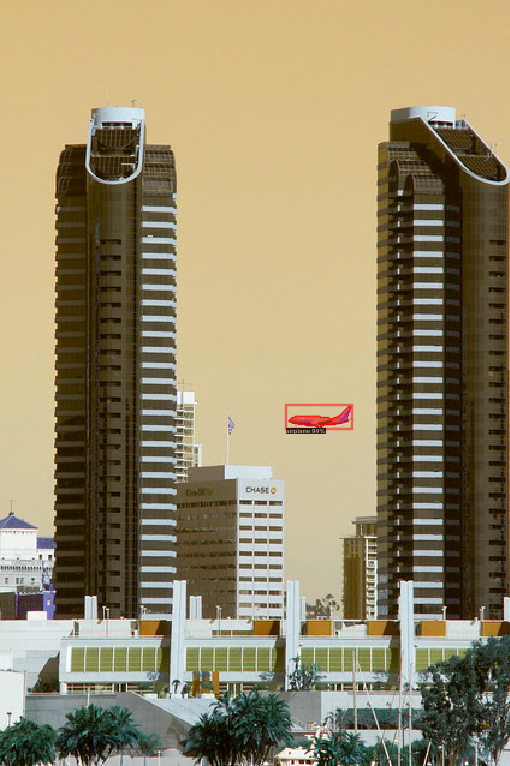

\Croped image



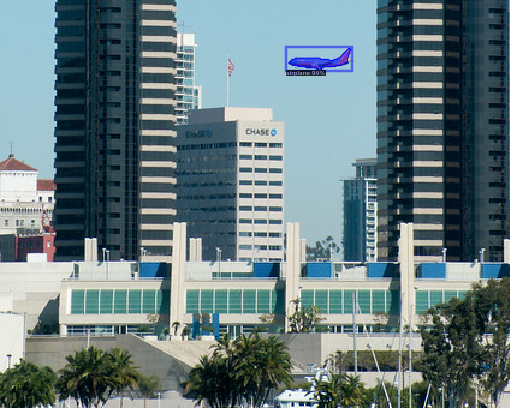

In [45]:
dir_path = "/content/images"
c = Cropper(dir_path)
for i in range(6):
  c.detect_and_crop(i)
  